Resolución ejercicio 12)c) de la guía de algoritmos genéticos.

Para la resolución voy a utilizar una librería que encontré en un libro que se llama "deap". Tiene muchas herramientas pero algunas de las que vimos en la materia no. Por lo tanto, agregué algunas funciones que explicaré a medida que avanza el ejercicio. También explicaré las funciones que sí tiene la librería.

En primer lugar, instalaré la librería con la función "pip".

In [1]:
!pip install deap

     |████████████████████████████████| 163kB 2.7MB/s 


En segundo lugar, importaré algunas funciones de la librería "deap" junto con otras funciones ya conocidas y utilizadas anteriormente para hacer cálculos y gráficos.

Es importante destacar la lines "import elitism", que es un archivo que nos va a permitir utilizar el elitismo a la hora de la selección. Más adelante desarrollaremos.

In [0]:
from deap import base
from deap import creator
from deap import tools

import random
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import elitism

En este bloque simplemente graficaremos la función a minimizar. Aquí podemos intuir una solución para X = 5 con un valor de f = 0 .

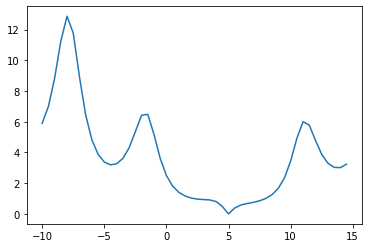

In [7]:
x_0 = np.arange(-10, 15, 0.5)
ff = np.zeros(shape = (len(x_0), 1))

for i in range(len(x_0)):
  ff[i] = np.abs((x_0[i] - 5) / (2 + math.sin(x_0[i])))

plt.plot(x_0, ff)

Antes de empezar a diseñar se setearan las constantes. Elegimos una población con tamaño 100, un 80% de porcentaje de crossover, un 20% para la mutación, una cantidad de generaciones máxima igual a 20 y una cantidad de individuos igual a 10 (los 10 mejores) para que pasen directamente a la siguiente generación.

In [0]:
POPULATION_SIZE = 100
P_CROSSOVER = 0.8
P_MUTATION = 0.2 
MAX_GENERATIONS = 20
HALL_OF_FAME_SIZE = 10

Aquí debo explicar lo principal que agregué a la librería. "DEAP" es una librería de algoritmos genéticos pero no tiene funciones de "crossover" ni "mutation" para número reales que trabajen bit a bit. Entonces, lo que hice fue trabajar con una función binaria, es decir, cada individuo es un arreglo de "1's" y "0's". Sin embargo, a la hora de evaluar la función de coste, paso ese arreglo de bits a números reales y recién evaluo en la función de coste. 

Luego cuando hago crossover y mutation lo hago con los individuos que son arreglos binarios, pero para evaluar en la función hago un pasaje de binario a real. Lo lindo es que es muy sencillo y funciona siempre. 

Para esto tengo que setear manualmente los límites ([-10 : 15] en este caso) y la cantidad de bits con los que voy a trabajar (10 en este caso, 5 para la parte real y 5 para la parte decimal).

También arreglo mediante dos simples "if" el caso para el cuando me paso de los límites. Creo que no es la mejor manera de hacerlo, pero seguramente es la más sencilla y funciona de maravilla, incluso para caso con 2 o 3 variables! 

Una última aclaración, la función roulette funciona solamente para maximizar variables y cuando las funciones son todas positivas. En el caso de funciones positivas, no hay problemas debido al valor absoluto que tiene la función (si lo hubiese habría que agregar un offset) pero en el caso de maximizar una función, sí. 

Como lo que pide el ejercicio es minimizar la función, simplemente la apliqué un signo menos a la función para que ahora lo que el algoritmo tenga que hacer es maximizarla y no minimizarla.

Tal vez, la explicación no es muy buena, pero fue todo a ojo tratando de acomodarme a las herramientas que tenía, cualquier cosa estoy a su disposición para consultas.

In [0]:
def function_mini(individual):
    x = -13.5
    for bin in range(10):
      x += individual[bin] * 2**(5 - bin)
    
    if x > 15:
      x = 15
    elif x < -10:
      x = -10

    f = np.abs((x - 5) / (2 + math.sin(x)))
    return -f, 

Aquí comienza la parte en la que uso la librería. Basicamente lo que hago aquí es:
1. definir que lo que quiero hacer es maximizar la función
2. crear un arreglo binario de 10 elementos para cada individuo
3. crear una población de los individuos creados anteriormente
4. asignar la funcion definida en el bloque anterior para que la utilice como función de coste
5. asignar el método Roulette como método de selección
6. asignar el método Two-Point para el crossover a los individuos binarios
7. asignar el método Flip-Binario para la mutación y también la probabilidad con la eso pase (asigné 1/ (el largo del string) como decía en la bibliografía) 

In [16]:
toolbox = base.Toolbox()
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox.register("zeroOrOne", random.randint, 0, 1)
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.zeroOrOne, 10)
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)
toolbox.register("evaluate", function_mini)
toolbox.register("select", tools.selRoulette)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/10)

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Aquí se crea a la población con los métodos creados anteriormente. Se crean algunas variables que almacenarán datos para luego poder graficar. Se crea la variable "Hall of Fame" que es basicamente la función de elite.

Y, finalmente, se ejecuta el algoritmo. Para esto se utiliza una librería llamada "elitism" que permite que los mejores individuos pasen directamente. Todos los parámetros que pide la función son los que definimos en los bloques anteriores.

In [0]:
population = toolbox.populationCreator(n=POPULATION_SIZE)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=False)
maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

Ahora graficamos con las estadisticas recolectadas anteriormente. En rojo vemos el fitness del mejor elemento a los largo de las generaciones y en verde el valor del promedio de toda la población.

Aparentemente a partir de la generación 5, ya se estabiliza, esto es debido a que use una población alta (100). Esos valores se pueden modificar facilmente en el primer bloque.

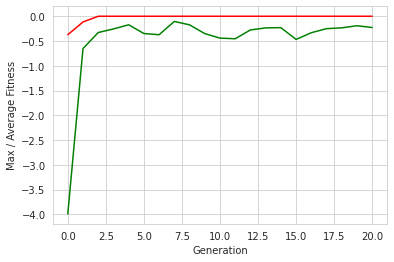

In [19]:
sns.set_style("whitegrid")
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')

plt.show()

Por último, observamos los resultados. El mejor individuo tiene un fitness igual a 0 en X = 5 como intuimos al comienzo del ejercicio.

In [21]:
best = hof.items[0]

x = -13.5
for bin in range(10):
  x += best[bin] * 2**(5 - bin)
if x > 15:
  x = 15
elif x < -10:
  x = -10
f = np.abs((x - 5) / (2 + math.sin(x)))

print("El fitness vale ",f,"para X =",x)

El fitness vale  0.0 para X = 5.0
